# Accompanying notebook to Optimization Stories in Logistics and Transportation

By Joaquim Gromicho, ORTEC & The Analytics Academy, 2020


## General introduction 
The notebooks used in this tutorial make extensive use of [markdown](https://en.wikipedia.org/wiki/Markdown) of which [here](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) you may find a very comprehensive summary. May you like a document that you can print, fold and take with you then you may like to check [this](https://enterprise.github.com/downloads/en/markdown-cheatsheet.pdf).

We also draw pictures on our notebooks. Therefore we need the [magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) below. 

In [1]:
%matplotlib inline

## About being pythonic

If you program, then reading [this](https://docs.python-guide.org/writing/style/) will help you writing code that feels _natural_ in python. You may also like to uncomment the following statement for some introspection 😉 

In [2]:
# import this

## Dependencies

The `import` statement on the cell above is special... it imports programmer's wisdom!
The usual usage is to acquire access to python packages.

In [3]:
import sympy
import math

# Alice's story: Nothing beats an optimum!

<img style="float: right;" src="pics/RoseInGlass.jpg">

You  heard the story of Alice and her efforts to determine the _optimal_ level of water for her rose on a lemonade glass.

You may recall that the _center of gravity_ of the glass with water is at 
$h = \frac{m_w}{m_w+m_g} h_w + \frac{m_g}{m_w+m_g} h_g$ with:

* $m_w$ the mass of water 
* $m_g$ the mass of glass
* $h_w$ the height of the center of gravity of the water in the glass
* $h_g$ the height of the center of gravity of the glass without water 

Since Alice's glass is $20$ cm tall, $4$ cm wide and weighs $100$ gram, Alice could fill the glass with water up to height $x$ cm, provided $0 \leq x \leq 20$ since the water must fit in the glass.

The volume of water is $\pi r^2 x$ with $r$ the radius of the base, i.e. $r=2$. 
The volume is therefore $4\pi x$ cubic centimeters. 

Since the density of water can be [taken](https://en.wikipedia.org/wiki/Gram_per_cubic_centimetre) as being $1$ gram per cubic centimeter we have:

* $m_w = 4\pi x$
* $m_g = 100$
* $h_w = \frac{x}{2}$
* $h_g = \frac{20}{2} = 10$ 

And from here we finally obtain the following formula for the height of the center of gravity of the glass with water:

$$
h = \frac{4\pi x}{4\pi x + 100} \frac{x}{2} + \frac{100}{4\pi x + 100} 10 = \frac{4\pi x^2 + 2000}{8\pi x + 200}
$$

Alice's problem is therefore:

$$
\begin{array}{rl}
\min    & \frac{4\pi x^2 + 2000}{8\pi x + 200}  \\
s.t.    & x \geq 0   \\
        & x \leq 20  \\
\end{array}
$$


This is a good moment to play with symbolic mathematics in python, we will use [sympy](https://www.sympy.org/en/index.html).

## With $\pi$ as a number

In [4]:
x  = sympy.Symbol('x')
pi = math.pi

h  = (4*pi*x**2 + 2000)/(8*pi*x+200)

sympy.solveset( sympy.diff( h, x ), x )

{-22.8735335189926, 6.95803920980307}

## With $\pi$ as a symbol

In [5]:
pi = sympy.Symbol('pi')

h = (4*pi*x**2 + 2000)/(8*pi*x+200)

sympy.solveset( sympy.diff( h, x ), x )

{-5*sqrt(5)*sqrt(4*pi + 5)/pi - 25/pi, 5*sqrt(5)*sqrt(4*pi + 5)/pi - 25/pi} \ {-25/pi}

## Forcing formulas to pretty display using $\LaTeX$

In [6]:
def Preety( formula ):
    from sympy import latex
    from IPython.display import display, Math
    display( Math( latex( formula ) ) )

Preety( h )

derivative = sympy.diff( h, x )
    
Preety( derivative )

Preety( sympy.simplify( derivative ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## From a symbolic $\pi$ to a numeric $\pi$

In [7]:
solution = sympy.solveset( derivative, x )

Preety( solution )

s = max(solution.subs( pi, math.pi ).evalf())

print(s)

<IPython.core.display.Math object>

6.95803920980307


## A picture says more than thousand words

In [8]:
def Plot( h, s, start, stop, width=18, height=8 ):
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (18,8)

    x = sympy.Symbol('x')
    f = sympy.lambdify( x, h.subs( pi, math.pi ) )

    import numpy
    x = numpy.linspace(start=start,stop=stop,num=100) 
    y = f(x)

    plt.plot(x,y,label='$'+sympy.latex(h)+'$',linewidth=3)
    plt.plot(s,f(s), 'ro', label='optimum', markersize=12)

    plt.legend()
    plt.show() 

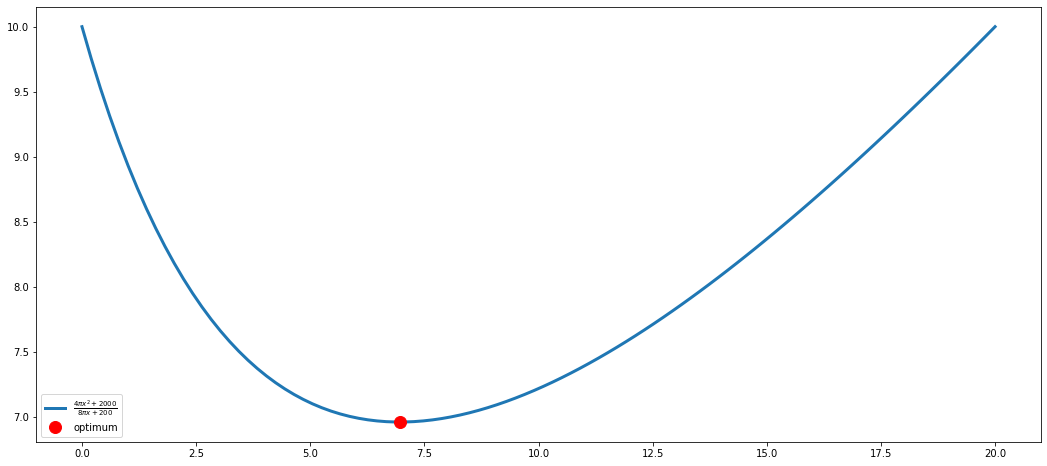

In [9]:
Plot( h, max(solution.subs( pi, math.pi ).evalf()), 0, 20 )

## What if we only care about the numerical solution?

This is the moment to meet powerful numerical algorithms and how to use them. 

We now meet [`pyomo`](http://www.pyomo.org/documentation/) which will keep us company for the rest of the tutorial. 
Note that in particular you may find this [slide-deck](https://software.sandia.gov/downloads/pub/pyomo/Pyomo-Workshop-Summer-2018.pdf) quite useful. 

`pyomo` completely separates modeling from solving, which allows us to switch solver without recoding! 

In [10]:
import math
from pyomo.environ import ConcreteModel, Var, Objective, minimize
alice     = ConcreteModel('Alice')
alice.h   = Var( bounds=(0,20) )
alice.cog = Objective(expr= (4*math.pi*alice.h**2 + 2000)/(8*math.pi*alice.h+200),sense= minimize)
alice.pprint()

1 Var Declarations
    h : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :    20 : False :  True :  Reals

1 Objective Declarations
    cog : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (12.566370614359172*h**2 + 2000)/(25.132741228718345*h + 200)

2 Declarations: h cog


In [11]:
from pyomo.environ import SolverManagerFactory
%time results = SolverManagerFactory('neos').solve( alice, opt='ipopt')
print(results.solver.status, results.solver.termination_condition )
alice.pprint()

Wall time: 1min 5s
ok optimal
1 Var Declarations
    h : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 6.95803921230998 :    20 : False : False :  Reals

1 Objective Declarations
    cog : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (12.566370614359172*h**2 + 2000)/(25.132741228718345*h + 200)

2 Declarations: h cog


In [12]:
alice.display()

Model Alice

  Variables:
    h : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 6.95803921230998 :    20 : False : False :  Reals

  Objectives:
    cog : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 6.95803920980307

  Constraints:
    None


In [13]:
alice.h.value

6.95803921230998

In [14]:
alice.cog.expr()

6.95803920980307

It is also worth learning more about [magics](https://ipython.readthedocs.io/en/stable/interactive/magics.html), try the magic `%time` above before `solve`.